#Implement two hidden layers neural network classifier from scratch in JAX


##1. Importing Libraries: numpy, jax, PyTorch

  PyTorch libraries for MNIST dataset and creating a DataLoader

In [24]:
import numpy as np
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jax import jit, vmap, pmap, grad, value_and_grad

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

##2. Multi Layer Perceptron (MLP) Initialisation

In [17]:
seed = 0
mnist_img_size = (28, 28)

#initialising a multi-layered perceptron
def init_MLP(layer_widths,parent_key,scale = 0.01):
  params = []
  keys = jax.random.split(parent_key, num = len(layer_widths)-1)
  
  for in_width, out_width, key in zip(layer_widths[:-1], layer_widths[1:], keys):
    weight_key, bias_key = jax.random.split(key)
    params.append([
            scale * jax.random.normal(weight_key, shape = (out_width,in_width)), 
            scale * jax.random.normal(bias_key, shape = (out_width,))
            ] 
    )
  return params

#testing function
key = jax.random.PRNGKey(seed)

MLP_params = init_MLP([784,512,256,10],key)
print(jax.tree_map(lambda x: x.shape, MLP_params))


[[(512, 784), (512,)], [(256, 512), (256,)], [(10, 256), (10,)]]


##3. Prediction Function

Creating two hidden layers and using 'relu' as an activation function. 

activation := dot product[(weights)(activation)] + bias

In [37]:
#creating prediction function
def MLP_predict(params, x):
  hidden_layers = params[:-1]

  activation = x
  for w,b in hidden_layers:
    activation = jax.nn.relu(jnp.dot(w,activation)+b)

  w_last, b_last = params[-1]
  logits = jnp.dot(w_last,activation)+b_last

  return logits - logsumexp(logits)

batched_MLP_predict = vmap(MLP_predict, in_axes=(None, 0))

dummy_imgs_flat = np.random.randn(16, np.prod(mnist_img_size))
print(dummy_imgs_flat.shape)
predictions = batched_MLP_predict(MLP_params, dummy_imgs_flat)
print(predictions.shape)

(16, 784)
(16, 10)


##4. Data Collection from MNIST Dataset

Creating a transform and collate function to properly shape the data.

Testing it with the batched data and optimising it for better performance

In [42]:
def custom_transform(x):
    return np.ravel(np.array(x, dtype=np.float32))

def custom_collate_fn(batch):
    transposed_data = list(zip(*batch))

    labels = np.array(transposed_data[1])
    imgs = np.stack(transposed_data[0])

    return imgs, labels

batch_size = 128
train_dataset = MNIST(root='train_mnist', train=True, download=True, transform=custom_transform)
test_dataset = MNIST(root='test_mnist', train=False, download=True, transform=custom_transform)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

# test
batch_data = next(iter(train_loader))
imgs = batch_data[0]
lbls = batch_data[1]
print(imgs.shape, imgs[0].dtype, lbls.shape, lbls[0].dtype)

# optimization
train_images = jnp.array(train_dataset.data).reshape(len(train_dataset), -1)
train_lbls = jnp.array(train_dataset.targets)

test_images = jnp.array(test_dataset.data).reshape(len(test_dataset), -1)
test_lbls = jnp.array(test_dataset.targets)

(128, 784) float32 (128,) int64


##5. Loss function, Accuracy function, Update Function

Loss function takes MLP parameters, images and the labels as parameters and returns the loss value.

Accuracy function returns the total correct predictions for all the predictions. 

Update function uses gradient descent with the help of "tree_multimap" from the JAX library.

The number of epochs are set to 5 for faster computation.

Therefore, the loop is trained with the help of these three functions.

In [ ]:
num_epochs = 5

def loss_fn(params, imgs, gt_lbls):
    predictions = batched_MLP_predict(params, imgs)

    return -jnp.mean(predictions * gt_lbls)

def accuracy(params, dataset_imgs, dataset_lbls):
    pred_classes = jnp.argmax(batched_MLP_predict(params, dataset_imgs), axis=1)
    return jnp.mean(dataset_lbls == pred_classes)

@jit
def update(params, imgs, gt_lbls, lr=0.01):
    loss, grads = value_and_grad(loss_fn)(params, imgs, gt_lbls)

    return loss, jax.tree_multimap(lambda p, g: p - lr*g, params, grads)

MLP_params = init_MLP([np.prod(mnist_img_size), 512, 256, len(MNIST.classes)], key)

for epoch in range(num_epochs):

    for cnt, (imgs, lbls) in enumerate(train_loader):

        gt_labels = jax.nn.one_hot(lbls, len(MNIST.classes))
        
        loss, MLP_params = update(MLP_params, imgs, gt_labels)
        
        if cnt % 50 == 0:
            print(loss)

    print(f'Epoch {epoch}, train acc = {accuracy(MLP_params, train_images, train_lbls)} test acc = {accuracy(MLP_params, test_images, test_lbls)}')


##6. Sample visualisation and prediction of the model

Here, a random image from the test set is used to predict. 
With the help of "matplotlib" library, it is shown that the the predicted result and labeled value is the same.

(28, 28)
predicted:  9
gt:  9


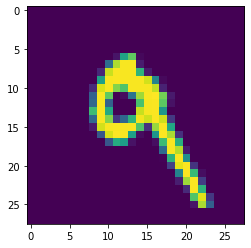

In [51]:
imgs,lbls = next(iter(test_loader))
img = imgs[7].reshape(mnist_img_size)
gt_lbl = lbls[7]
print(img.shape)

import matplotlib.pyplot as plt

pred = jnp.argmax(MLP_predict(MLP_params, np.ravel(img)))
print('predicted: ', pred)
print('gt: ', gt_lbl)
plt.imshow(img)
plt.show()

##7. Checking the accuracy score of the model for both training and testing set

In [70]:
train_accuracy = accuracy(MLP_params, train_images, train_lbls) 
test_accuracy = accuracy(MLP_params, test_images, test_lbls)
print(train_accuracy)
print(test_accuracy)

0.9607667
0.95589995


The model created is an example of a multi-layered perceptron. This model is created with two hidden layers. The weights and biases are taken to be random numbers using the jax.random. 

The neural networks are then initialised with the vmap() function from the JAX library. This function helped in batching the complete predict() function in this experiment.

The neurons in each layer are manually optimised with the help of jnp.array() function. 

Finally, the accuracy of the model is <b>96.07%</b> for the <b>training set</b> and <b>95.59%</b> for the <b> test set</b>. 

## Missing work
1. The <b>loss v/s iteration curve</b> was difficult to make as creating the training model for each epoch required using optax library.

2. The analysis using different <b>Classification Metrics</b> was not done due to errors while creating functions for each metric. Moreover, the metrics part required use of other libraries like sklearn. Module called as sklearn.metrics can be used for the Classification purposes.

Due to the above reasons, loss/iteration graph and classification metrics were not done.

##References
1. JAX Documentation: https://jax.readthedocs.io/en/latest/notebooks/quickstart.html
2. PyTorch Utils: https://pytorch.org/docs/stable/data.html

3. SciPy Special Module: https://docs.scipy.org/doc/scipy/reference/special.html
4. Neural Network Fundamentals from www.deeplearning.ai articles and blogs.

5. Kaggle(www.kaggle.com) Code for better undestanding of using JAX library.

6. AI Epiphany Youtube Channel (www.youtube.com) for learning basics of JAX library and its modules. 
